In [2]:
import pointCollection as pc
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import h5py
%matplotlib notebook
#%matplotlib widget
import scipy.interpolate as si
import scipy.sparse as spa
import scipy.stats as ss
import h5py
import os
import re
import matplotlib.gridspec as gridspec
import scipy.signal as sps

#import pandas as pd
#import seaborn as sns

version='rel002_zsurf.h5'
#version='v2_SMB.h5'

# change this data root to match your own
#data_root = '/Users/ben/Data/SMB'
#data_root='/Volumes/ice2/ben/MAR/ATL11_with_corrections/'
data_root='/home/ben/SMB_data'

In [3]:
%load_ext autoreload
%autoreload 2

In [44]:
cc=plt.rcParams['axes.prop_cycle'].by_key()['color']
#plt.figure()

#for ii in range(10): 
#    plt.plot(np.array([0, 10]), np.array([ii, ii]), linewidth=2)
colors={}
colors['hm'] = ['k']+[cc[ii] for ii in [2, 9]]  # black (data),2 green (corrected), 9 cyan(scaled correction)
colors['smb_fac'] = [cc[ii] for ii in [2, 8, 3, 1]] # 0 blue (corrected), 8 yellow (fac), 3 red smb, 1 orange(smb+fac)


In [5]:
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_sigma_lt_20.tif')
v_mask.index(np.arange(0, v_mask.shape[0], 5), np.arange(0, v_mask.shape[1], 5));
dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')
temp=np.ones_like(drainage_basins.z)
temp[gimp_mask.interp(drainage_basins.x, drainage_basins.y, gridded=True)<0.25]=0
temp[v_mask.interp(drainage_basins.x, drainage_basins.y, gridded=True)<0.25]=0
temp[temp==0]=np.NaN
drainage_basins.assign({'z_masked':temp*drainage_basins.z});

In [6]:
def RDE(x, f=0.68, scale=0.5):
    xs=x.copy()
    xs=np.isfinite(xs)   # this changes xs from values to a boolean
    N=len(xs.nonzero()[0])
    if N<2 :
        return np.nan
    ind=np.arange(0.5, N)
    
    
    LH=np.interp(np.array([0.5-f/2, 0.5+f/2])*N, ind, np.sort(x[xs]))
    #print('LH =',LH)
    return (LH[1]-LH[0])*scale  # trying to get some kind of a width of the data ~variance


## read in the data file.  
The data were written by the 'reduce_firn_dh' notebook.  It contains one top-level group for each model, and beneath that, one group for each epoch.  Within each epoch, the data represent a 2.5-km blockmedian of the corrected elevation-change values.  This gives a smaller number of difference values for each region, and makes a file of reasonable size.

Applying the blockmedian to the drainage basin variable didn't work well (cells containing borders aren't represented well), so let's repeat the interpolation for the cell locations.

In [111]:
data_file=os.path.join(data_root+'/combined_xover_at_differences_'+version)
! ls -lt {data_file}
strings_xover = ['2018.Q4-2019.Q2','2019.Q1-2019.Q2']
strings_at=['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']
epochs=strings_xover+strings_at

D={}
D_unmasked={}
with h5py.File(data_file,'r') as h5f:
    models=list(h5f.keys())
    print(models)
for model in models:
    D[model]={}
    D_unmasked[model]={}
    for epoch in epochs:
        this_group='/'.join(['',model, epoch])
        D_unmasked[model][epoch]=pc.data().from_h5(data_file, group=this_group)
        D_unmasked[model][epoch].assign({'basin':np.floor(dbi.__call__((D_unmasked[model][epoch].y, D_unmasked[model][epoch].x))*10)/10})
        D[model][epoch] = D_unmasked[model][epoch][D_unmasked[model][epoch].vel_mask>0.1]


-rw-r--r-- 1 ben ben 206870650 Jan 21 11:11 /home/ben/SMB_data/combined_xover_at_differences_rel002_zsurf.h5
['GSFC_fdm_v1_1', 'MARv3_11_2_ERA_20km', 'MARv3_11_2_ERA_6km', 'MARv3_11_2_NCEP_20km']


In [145]:
np.mean(D_unmasked[model][epochs[1]].vel_mask>0.1)

0.9606367842906033

In [8]:
def N_sigma_edit_fit(G0, d0, n_sigma=3, n_iterations=5, good0=None, wt=None):
    if wt is None:
        wt=np.ones_like(d0)    
    if good0 is None:
        good0=np.all(np.isfinite(G0), axis=1) & np.isfinite(d0) & np.isfinite(wt)
    good=good0
    m=np.zeros(G0.shape[1])
    r=np.zeros(d0.shape)
    sigma=np.NaN
    good_last=np.zeros_like(good)
    for ii in range(n_iterations+1):
        G=G0[good,:]
        W=spa.diags(wt[good]/np.mean(wt[good]))
        if (G.shape[0]<G.shape[1]) or np.all(good_last==good):
            break
        m=np.linalg.solve(G.T.dot(W.dot(G)), G.T.dot(W.dot(d0[good])))
        r=d0-G0.dot(m)
        sigma=RDE(r[good])
        good=good0 & (np.abs(r)<n_sigma*sigma)

    return m, r, sigma, good

In [9]:
def calc_bvar(Dsub, fits, reg_model, wt):
    Wnorm = wt
    Wnorm /= Wnorm[[fits[reg_model]['ind']]].sum()
    uB=np.unique(np.floor(Dsub.basin));
    Bvar=np.zeros_like(uB)
    for basin in np.unique(np.floor(Dsub.basin)):
        temp= (np.floor(Dsub.basin)==basin) & fits[reg_model]['ind']
        Bvar[int(basin)-1]=np.sum(fits[reg_model]['r'][temp]**2*Wnorm[temp])
    return Bvar/np.sum(Bvar)

def map_bvar(Bvar, basin_map):
    var_map=basin_map.copy()
    for basin in range(1, len(Bvar)+1):
        ii=np.floor(basin_map.z)==basin
        var_map.z[ii]=Bvar[basin-1]
    var_map.show()

def map_density(D, basin_map, wt=None):
    if wt is None:
        wt=np.ones_like(D.x)
    rho_map=basin_map.copy()
    rho_map.z=basin_map.z.copy()+np.NaN
    cell_area=np.diff(basin_map.x[0:2])**2
    print(cell_area)
    for basin in range(1, len(Bvar)+1):
        im=np.floor(basin_map.z_masked)==basin
        this_rho=np.sum(wt[np.floor(D.basin)==basin])/(np.sum(im)*cell_area)
        print(f"this_rho={this_rho}")
        print(f"this_area={np.sum(im)*cell_area}")
        rho_map.z[im]=this_rho
    return rho_map

def smooth_pt_density(D, res=1.e4, kernel_size=5):
    count_grid=pc.points_to_grid(pc.apply_bin_fn(D, res,  lambda a,b:len(b)), res=res)
    count_grid.z[~np.isfinite(count_grid.z)]=0
    count_grid.z=sps.convolve2d(count_grid.z, np.ones([kernel_size,kernel_size])/kernel_size**2, mode='same')
    #plt.figure(); 
    #count_grid.show()
    return count_grid

def smooth_var(D, res=1.e4, kernel_size=5):
    var_grid=pc.points_to_grid(pc.apply_bin_fn(D, res,  lambda a,b:np.mean(a.r[b]**2)), res=res)
    var_grid.z[~np.isfinite(count_grid.z)]=0
    var_grid.z=sps.convolve2d(var_grid.z, np.ones([kernel_size,kernel_size])/kernel_size**2, mode='same')
    #plt.figure(); 
    #count_grid.show()
    return var_grid

def make_pt_density_parameter(D, res=1.e4, kernel_size=5):
    D_all=pc.data().from_list([D[key] for key in D.keys()])
    pt_density_grid=smooth_pt_density(D_all, res, kernel_size)
    for key, item in D.items():
        item.assign({'pt_density':pt_density_grid.interp(item.x, item.y)})

In [10]:
def melt_threshold_map(D, res=5.e3, kernel_size=5):
    threshold_grid=pc.points_to_grid(pc.apply_bin_fn(D, res,  lambda a,b:np.max(a.z_melt[b]) > 0.02), res=res)
    threshold_grid.z[~np.isfinite(count_grid.z)]=0
    threshold_grid.z=sps.convolve2d(threshold_grid.z, np.ones([kernel_size,kernel_size])/kernel_size**2, mode='same')
    #plt.figure(); 
    #count_grid.show()
    return count_grid


In [113]:
for key in D.keys():
    make_pt_density_parameter(D[key], res=1.e4, kernel_size=3)

[-600000.0, 760000.0]
[-600000.0, 770000.0]
[-600000.0, 760000.0]
[-600000.0, 770000.0]


In [79]:
# check that the weighting scheme does as we expect (assigns consistent weighted variance to all basins)
D_all=pc.data().from_list([D['GSFC_fdm_v1_1'][key] for key in D['GSFC_fdm_v1_1'].keys()])
D_all.index((D_all.vel_mask > 0.1) & (np.isfinite(D_all.pt_density)))
G=np.ones_like(D_all.pt_density).reshape((D_all.size,1))
d=np.random.randn(G.size)
m, r, sigma, good = N_sigma_edit_fit(G, d, n_sigma=3, n_iterations=5, wt=1/D_all.pt_density)

ww=1/D_all.pt_density
Wnorm=ww/(ww).mean()
v_basin=np.arange(1,9)+np.NaN
sigma_basin=v_basin.copy()
for basin in range(1,9):
    these=np.floor(D_all.basin)==basin
    these &= good
    basin_area=np.sum(np.floor(drainage_basins.z_masked)==basin)
    v_basin[basin-1] = np.sum(r[these]**2*Wnorm[these])/basin_area
    sigma_basin[basin-1] = np.sqrt(np.sum(r[these]**2*Wnorm[these])/np.sum(Wnorm[these]))
print("Variance per unit area, per basin:")
print(v_basin)
print("Sigma per basin:")
print(sigma_basin)
# the answers are within 25% of unity.  high-five self and move on.

Variance per unit area, per basin:
[1.08708857 1.08813734 0.93155407 0.75505526 0.75940783 1.04975544
 1.01412561 1.02854429]
Sigma per basin:
[0.98306915 0.98746314 0.98228341 0.98836328 0.97972662 0.98184961
 0.98239282 0.9868942 ]


## The problem:

<IPython.core.display.Javascript object>


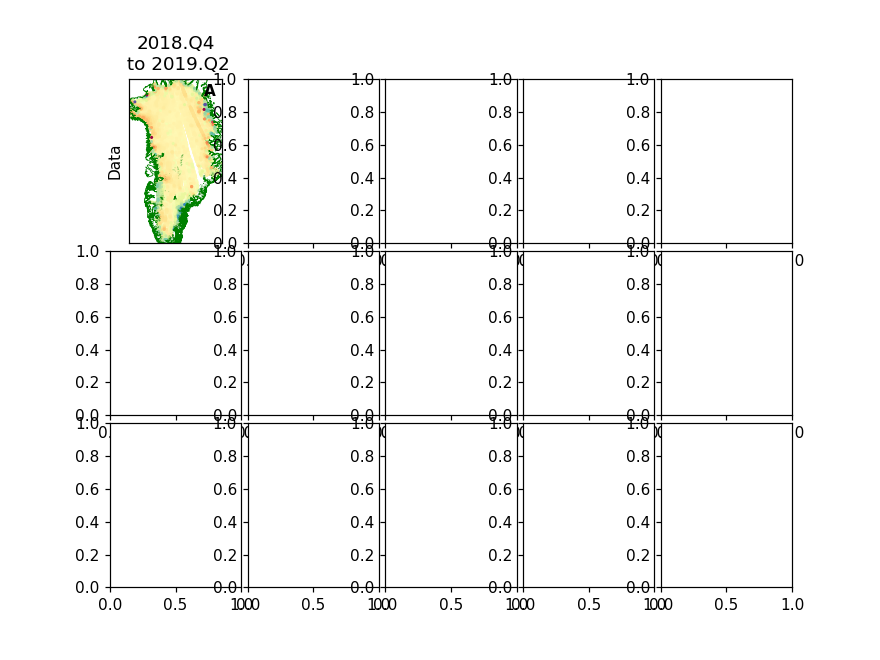

<IPython.core.display.Javascript object>


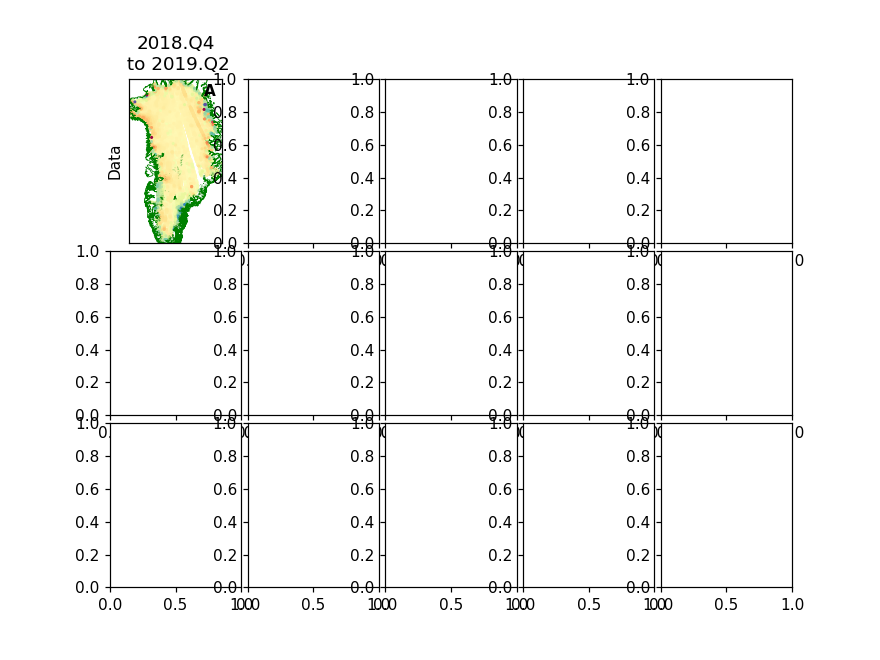

In [150]:
xx=D[models[0]][epochs[0]].x
XR_default=[np.min(xx)-2.e4, np.max(xx)+1.e4]
yy=D[models[0]][epochs[0]].y
YR_default=[np.min(yy)-2.e4, np.max(yy)+1.e4]

alphabet='ABCDEFGHIJKLMNOP'
letter_pos = [XR_default[-1]-0.2*(XR_default[-1]-XR_default[0]), YR_default[-1]-0.1*(YR_default[-1]-YR_default[0])]
strings=epochs
for plot_type in ['model','corrected']:
    count=0
    fig=plt.figure(figsize=[8, 6])
    ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
    for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
        for col, epoch in enumerate(epochs):
            if row==0:
                ax[row, col].set_title(epoch.replace('-','\n to '))
            if col==0:
                ax[row, col].set_ylabel(model)
            if model == 'Data':
                #this_D=D_unmasked['MARv3_11_2_ERA_6km']
                this_D=D['MARv3_11_2_ERA_6km']
                temp=this_D[epoch]
                dh=temp.data
            else:
                #this_D=D_unmasked[model]
                this_D=D[model]
                temp=this_D[epoch]
                if plot_type=='model':
                    dh=temp.model
                else:
                    dh=temp.data-temp.model    
            ind=np.argsort(np.abs(dh))
            #print(np.mean(temp[np.isfinite(dh)].vel_mask > 0))
            if len(ind) > 0:
                hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
                    vmin=-2.5, vmax=2.5, cmap='Spectral');
            ax[row, col].contour(v_mask.x, v_mask.y, v_mask.z, [0.1], colors='green', origin='lower', linewidths=0.5)

            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            ax[row, col].set_aspect(1)
            ax[row, col].set_xlim(XR_default)
            ax[row, col].set_ylim(YR_default)
            ax[row, col].text(*letter_pos, alphabet[count], ma='center', fontweight='bold'); count+=1
            break
        break

    #plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label=plot_type+' $\delta h$, m')


<IPython.core.display.Javascript object>


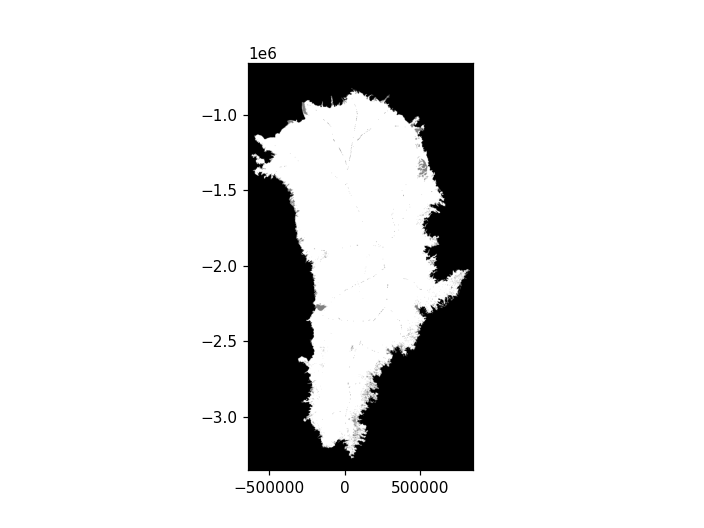

In [157]:
plt.figure()
plt.imshow(np.isfinite(drainage_basins.z_masked).astype(float)+np.isfinite(drainage_basins.z).astype(float), extent=drainage_basins.extent, origin='lower', cmap='gray')
#plt.scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
#                    vmin=-2.5, vmax=2.5, cmap='Spectral');

In [151]:
drainage_basins

<class 'pointCollection.grid.data.data'> with shape (1346, 746),
with fields:
['z', 'z_masked']

In [142]:
count           

16

In [132]:
v_mask

<class 'pointCollection.grid.data.data'> with shape (2740, 1517),
with fields:
['z']

In [13]:
def basin_regessions(D, model, basins, epochs, h_range, fits=None, fn=None, wt_field=None, n_sigma=6, initial_iterations=10):

    temp=[]
    #mu_sigma_str = '\n$\mathbf{\mu}$=%3.3f m, $\mathbf{\sigma}$=%3.3f m'

    for basin in basins:
        for ind, epoch in enumerate(epochs):
            these = np.floor(D[model][epoch].basin)==basin
            these &= (D[model][epoch].h0 > h_range[0]) & (D[model][epoch].h0 < h_range[1])
            temp1=D[model][epoch][these]
            temp1.assign({'epoch':np.zeros_like(temp1.x)+ind})
            temp += [temp1]
            
    Dsub=pc.data().from_list(temp)
    Dsub.index(np.isfinite(Dsub.mean))
    if fn is not None:
        Dsub=fn(Dsub)
    h_star = (Dsub.h0-2000)/2000
    RDE_params={'f':0.95, 'scale':0.25}
    
    calc=False
    if fits is None:
        calc=True
        fits={}
    
    n_it=0
    
    if wt_field is None:
        wt=np.ones_like(Dsub.x)
    if wt_field=='pt_density':
        wt=1/Dsub.pt_density
    
    key='A'
    G = np.c_[np.ones_like(Dsub.model)]
    if calc:
        m, r, sigma, good_0=N_sigma_edit_fit(G, Dsub.data, n_sigma=n_sigma, n_iterations=initial_iterations, wt=wt)
    else:
        m=fits[key]['m']
        r=Dsub.data-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.dh)], r, n_sigma=n_sigma, n_iterations=10)[2]

    if wt is not None:
        w_norm = wt.copy()
        w_norm /= w_norm[good_0].sum()
    else:
        w_norm = np.ones_like(Dsub.x)
        
    sigma_all=np.sqrt(np.sum(r[good_0]**2*w_norm[good_0])/np.sum(w_norm[good_0])); 

    fits[key]={'m':m, 'r':r, 'sigma_ctr':sigma, 'sigma':sigma_all,\
               'ind':good_0,\
               'label':'dh' }
    key='A+dh_m'
    G = np.c_[np.ones_like(Dsub.model)]
    if calc:
        m, r, sigma, good=N_sigma_edit_fit(G[good_0,:], Dsub.corrected[good_0], n_sigma=n_sigma, n_iterations=n_it, wt=wt[good_0])
    else:
        m=fits[key]['m']
        r=Dsub.corrected-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.data)], r, n_sigma=n_sigma, n_iterations=10)[2]
    #sigma_all=np.std(r); #sigma_all=RDE(r, **RDE_params)
    sigma_all=np.sqrt(np.sum(r**2*w_norm[good_0])/np.sum(w_norm[good_0])); 

    fits[key]={'m':m, 'r':Dsub.corrected-G.dot(m), 'sigma_ctr':sigma, 'sigma':sigma_all,\
               'ind':good_0,\
               'label':'dh - $dh_m$'}
        
    key='A+B*dh_m'
    G=np.c_[np.ones_like(Dsub.model), Dsub.model]
    if calc:
        m, r, sigma, good = N_sigma_edit_fit(G[good_0,:], Dsub.data[good_0], n_sigma=n_sigma, n_iterations=n_it, wt=wt[good_0])
    else:
        m=fits[key]['m']
        r=Dsub.data-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.data)], r, n_sigma=n_sigma, n_iterations=10)[2]
    sigma_all=np.sqrt(np.sum(r**2*w_norm[good_0])/np.sum(w_norm[good_0])); 
    #sigma_all = np.std(r); #RDE(r, **RDE_params)
    fits[key] = {'m':m, 'r':Dsub.data-G.dot(m), 'sigma_ctr':sigma, 'sigma':sigma_all,\
                 'ind':good_0,\
                'label':'dh - %3.2f $dh_m$' }
    for key in fits:
        fits[key]['wt'] = wt
    return fits, Dsub

In [64]:
def smb_fdm_regressions(D, model, basins, epochs, h_range, fits=None, n_sigma=6, fn=None, wt_field=None):

    temp=[]
        
    for basin in basins:
        for ind, epoch in enumerate(epochs):
            these = np.floor(D[model][epoch].basin)==basin
            these &= (D[model][epoch].h0 > h_range[0]) & (D[model][epoch].h0 < h_range[1])
            temp1=D[model][epoch][these]
            temp1.assign({'epoch':np.zeros_like(temp1.x)+ind})
            temp += [temp1]
    Dsub=pc.data().from_list(temp)
    Dsub.index(np.isfinite(Dsub.mean))
    if fn is not None:
        Dsub=fn(Dsub)
    h_star = (Dsub.h0-2000)/2000
    RDE_params={'f':0.95, 'scale':0.25}
    
    calc=False
    if fits is None:
        calc=True
        fits={}
    
    n_it=0
    
    if wt_field is None:
        wt=np.ones_like(Dsub.x)
    if wt_field=='pt_density':
        wt=1/Dsub.pt_density
    
    key='A'
    G = np.c_[np.ones_like(Dsub.model)]
    if calc:
        m, r, sigma, good_0=N_sigma_edit_fit(G, Dsub.data, n_sigma=n_sigma, n_iterations=10, wt=wt)
    else:
        m=fits[key]['m']
        r=Dsub.data-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.dh)], r, n_sigma=n_sigma, n_iterations=10)[2]

    if wt is not None:
        w_norm = wt
        w_norm /= w_norm[good_0].sum()
    else:
        w_norm = np.ones_like(Dsub.x)
        
    sigma_all=np.sqrt(np.sum(r[good_0]**2*w_norm[good_0])/np.sum(w_norm[good_0])); 

    fits[key]={'m':m, 'r':r, 'sigma_ctr':sigma, 'sigma':sigma_all,\
               'ind':good_0,\
               'label':'dh' }

    key='A+dh_m'
    G = np.c_[np.ones_like(Dsub.model)]
    if calc:
        m, r, sigma, good=N_sigma_edit_fit(G[good_0,:], Dsub.corrected[good_0], n_sigma=n_sigma, n_iterations=n_it, wt=wt[good_0])
    else:
        m=fits[key]['m']
        r=Dsub.corrected-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.data)], r, n_sigma=n_sigma, n_iterations=10)[2]
    #sigma_all=np.std(r); #sigma_all=RDE(r, **RDE_params)
    sigma_all=np.sqrt(np.sum(r**2*w_norm[good_0])/np.sum(w_norm[good_0])); 

    fits[key]={'m':m, 'r':Dsub.corrected-G.dot(m), 'sigma_ctr':sigma, 'sigma':sigma_all,\
               'ind':good_0,\
               'label':'dh - $dh_m$'}

    key = 'A + B*FAC + SMB'
    G=np.c_[np.ones_like(Dsub.model), Dsub.fac]
    if calc:
        m, r, sigma, good = N_sigma_edit_fit(G[good_0,:], Dsub.data[good_0]-Dsub.smb[good_0], n_sigma=n_sigma, n_iterations=n_it, wt=wt[good_0])
    else:
        m=fits[key]['m']
        r=Dsub.data-Dsub.SMB-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.data)], r, n_sigma=n_sigma, n_iterations=n_it)[2]
    sigma_all=np.sqrt(np.sum(r**2*w_norm[good_0])/np.sum(w_norm[good_0])); 
    fits[key] = {'m':m, 'r':Dsub.data-G.dot(m), 'sigma_ctr':sigma, 'sigma':sigma_all,\
                                         'ind':good_0,\
                'label':'dh - (%3.2f $dh_{FAC}$ + $dh_{SMB}$ )' }    
  
    key = 'A + FAC + C*SMB'
    G=np.c_[np.ones_like(Dsub.model), Dsub.smb]
    if calc:
        m, r, sigma, good = N_sigma_edit_fit(G[good_0,:], Dsub.data[good_0]-Dsub.fac[good_0], n_sigma=n_sigma, n_iterations=n_it, wt=wt[good_0])
    else:
        m=fits[key]['m']
        r=Dsub.data-Dsub.FAC-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.data)], r, n_sigma=n_sigma, n_iterations=n_it)[2]
    sigma_all=np.sqrt(np.sum(r**2*w_norm[good_0])/np.sum(w_norm[good_0])); 

    fits[key] = {'m':m, 'r':Dsub.data-G.dot(m), 'sigma_ctr':sigma, 'sigma':sigma_all,\
                                         'ind':good_0,\
                'label':'dh - ( $dh_{FAC}$ + %3.2f $dh_{SMB}$ )' }    

    key = 'A + B*FAC +C*SMB'
    G=np.c_[np.ones_like(Dsub.model),  Dsub.fac, Dsub.smb]
    if calc:
        m, r, sigma, good = N_sigma_edit_fit(G[good_0,:], Dsub.data[good_0], n_sigma=n_sigma, n_iterations=n_it, wt=wt[good_0])
    else:
        m=fits[key]['m']
        r=Dsub.data-G.dot(m)
        sigma=N_sigma_edit_fit(np.c_[np.ones_like(Dsub.data)], r, n_sigma=n_sigma, n_iterations=10)[2]
    #sigma_all = np.std(r); #RDE(r, **RDE_params)
    sigma_all=np.sqrt(np.sum(r**2*w_norm[good_0])/np.sum(w_norm[good_0])); 
    fits[key] = {'m':m, 'r':Dsub.data-G.dot(m), 'sigma_ctr':sigma, 'sigma':sigma_all,\
                'ind':good_0,\
                'label':'dh -  (%3.2f $dh_{FAC}$ + %3.2f $dh_{SMB}$)',
                'G':G[good_0,:], 'd':Dsub.data[good_0]}    

    
    
    return fits, Dsub

In [15]:
def fit_hists(Dsub, fits, keys, colors=None, bins=None, wt_field=None, count_max=np.Inf, stats=None, linestyle='-', extra_text=None):
    if bins is None:
        bins=np.arange(-1.005,  1.005, 0.01)
    if colors is None:
        colors=[None*len(keys)]
    if stats=='all':
        stats='msR'
    for ii, key in enumerate(keys):
        #print(key)
        #print(fits[key]['m'])
        #print(fits[key]['label'])
        R2 = 1-fits[key]['sigma']**2/fits['A']['sigma']**2 
        if wt_field is None:
            wt=np.ones_like(fits[key]['r'][fits[key]['ind']])
        elif wt_field == 'pt_density':
            wt=1/Dsub.pt_density[fits[key]['ind']]
        
        if len(fits[key]['m'])==1:
            # the whole model is just the offset
            legend_str = fits[key]['label']
            if stats is not None:
                legend_str += '\n'
            if 'm' in stats:
                legend_str += '$\mu=%3.2f$, ' % (fits[key]['m'])
        else:
            legend_str = fits[key]['label'] % tuple(list(fits[key]['m'][1:]))
            if stats is not None:
                legend_str += '\n'
            if 'm' in stats:
                legend_str += '$\mu=%3.2f$, ' % fits[key]['m'][0]
        if 's' in stats:
            legend_str += '$\sigma=%3.2f$' % fits[key]['sigma']      
        if 'R' in stats:
            legend_str +=  ', $\mathbf{R^2}$=%2.2f' % (R2)
            
        good=np.isfinite(fits[key]['r'][fits[key]['ind']]) & np.isfinite(wt)
        nh, xh=np.histogram(fits[key]['r'][fits[key]['ind']][good] + fits[key]['m'][0], bins, weights=wt[good], density=True)
        xh=xh[0:-1]+0.5*np.diff(xh[0:2])
        if colors[ii] is not None:
            plt.plot(xh, nh, linewidth=2, color=colors[ii], label=legend_str, linestyle=linestyle)
            #plt.hist(fits[key]['r'][fits[key]['ind']], bins, color=colors[ii], label = legend_str)
        else:
            plt.plot(xh, nh, linewidth=2,  label=legend_str, linestyle=linestyle)
            #plt.hist(fits[key]['r'][fits[key]['ind']], bins, alpha=0.5, label = legend_str)
        if ii > count_max:
            break
    #plt.legend(bbox_to_anchor=[1.02, 1], loc=['upper left'])
    plt.xlabel('residual, m')
    plt.gca().set_yticks([])
    if stats is None:
        plt.legend()
    else:
        plt.legend(loc=[1.02, 0])


<IPython.core.display.Javascript object>


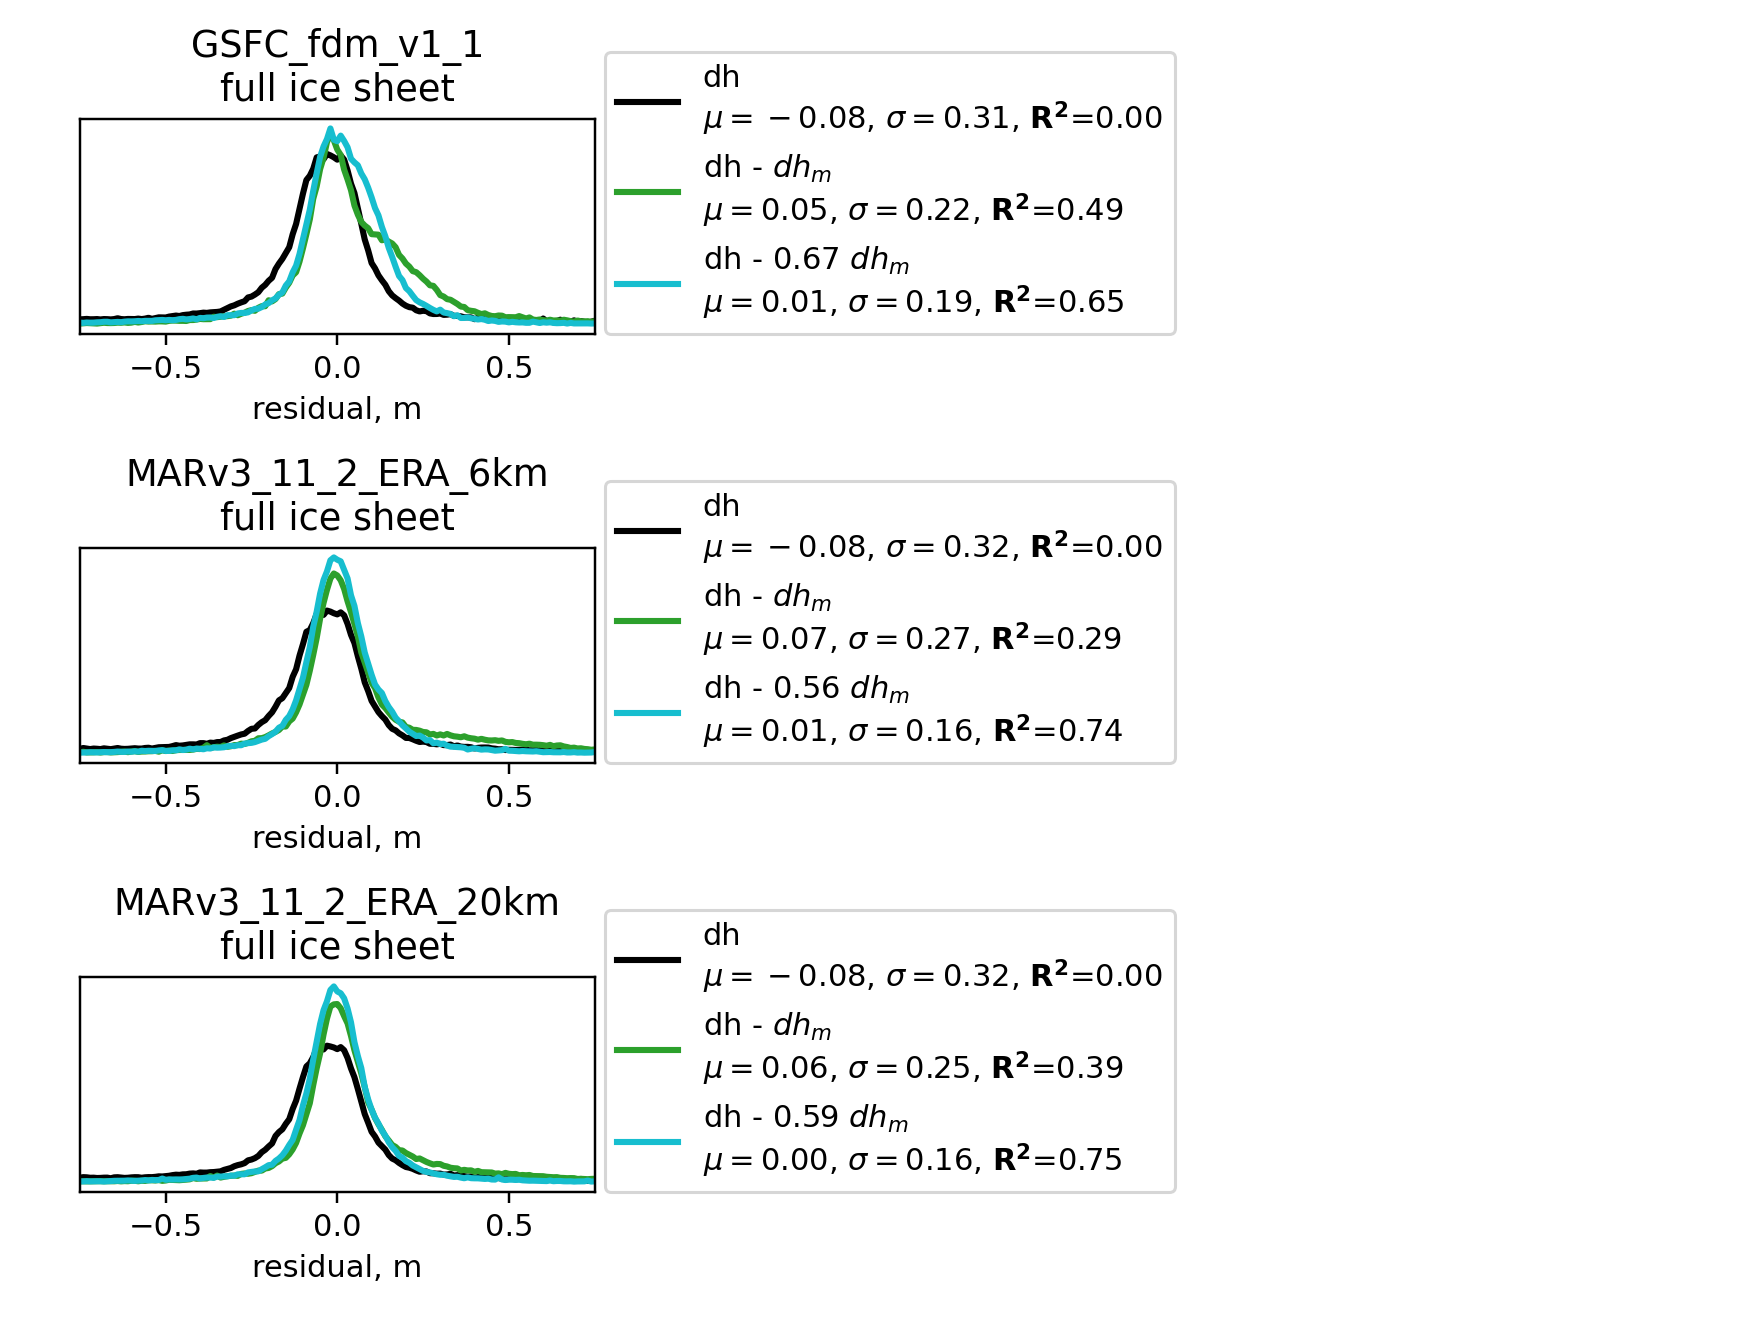

In [114]:

fig=plt.figure(figsize=[8, 6])
stats='msR'

model='GSFC_fdm_v1_1'
fits_12sigma, Dsub_12sigma = basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=12)

ax=fig.add_subplot(321)
fit_hists(Dsub_12sigma, fits_12sigma, fits_12sigma.keys(), colors['hm'], wt_field='pt_density', stats=stats, linestyle='-')#, extra_text=', \n$n \sigma$=12')


plt.title(model.replace('_zsurf','')+'\nfull ice sheet')
plt.gca().set_xlim([-0.75, 0.75])

#model='MARv3_11_2_ERA_20km'
model='MARv3_11_2_ERA_6km'
fits_12sigma, Dsub_12sigma = basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=12)
#fits_3sigma, Dsub_3sigma = basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=3)

#fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(323)
fit_hists(Dsub_12sigma, fits_12sigma, fits_12sigma.keys(), colors['hm'], wt_field='pt_density', stats=stats, linestyle='-')#, extra_text=', \n$n \sigma$=12')
#fit_hists(Dsub_3sigma, fits_3sigma, fits_3sigma.keys(), colors, wt_field='pt_density', stats=stats, linestyle='--', extra_text=', \n$n \sigma$=3')

plt.title(model.replace('_zsurf','')+'\nfull ice sheet')
plt.gca().set_xlim([-0.75, 0.75])

#model='MARv3_11_2_ERA_20km'
model='MARv3_11_2_ERA_20km'
fits_12sigma, Dsub_12sigma = basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=12)
#fits_3sigma, Dsub_3sigma = basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=3)

#fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(325)
fit_hists(Dsub_12sigma, fits_12sigma, fits_12sigma.keys(), colors['hm'], wt_field='pt_density', stats=stats, linestyle='-')#, extra_text=', \n$n \sigma$=12')
#fit_hists(Dsub_3sigma, fits_3sigma, fits_3sigma.keys(), colors, wt_field='pt_density', stats=stats, linestyle='--', extra_text=', \n$n \sigma$=3')

plt.title(model.replace('_zsurf','')+'\nfull ice sheet')
plt.gca().set_xlim([-0.75, 0.75])


plt.tight_layout()


In [45]:
#fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=12)
#fits, Dsub=basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density')
#print(fits.keys())
print(colors.keys())
plot_keys={'hm':['A', 'A+dh_m', 'A+B*dh_m'], \
    'smb_fac': ['A+dh_m', 'A + B*FAC + SMB', 'A + FAC + C*SMB', 'A + B*FAC +C*SMB']}

dict_keys(['hm', 'smb_fac'])


<IPython.core.display.Javascript object>


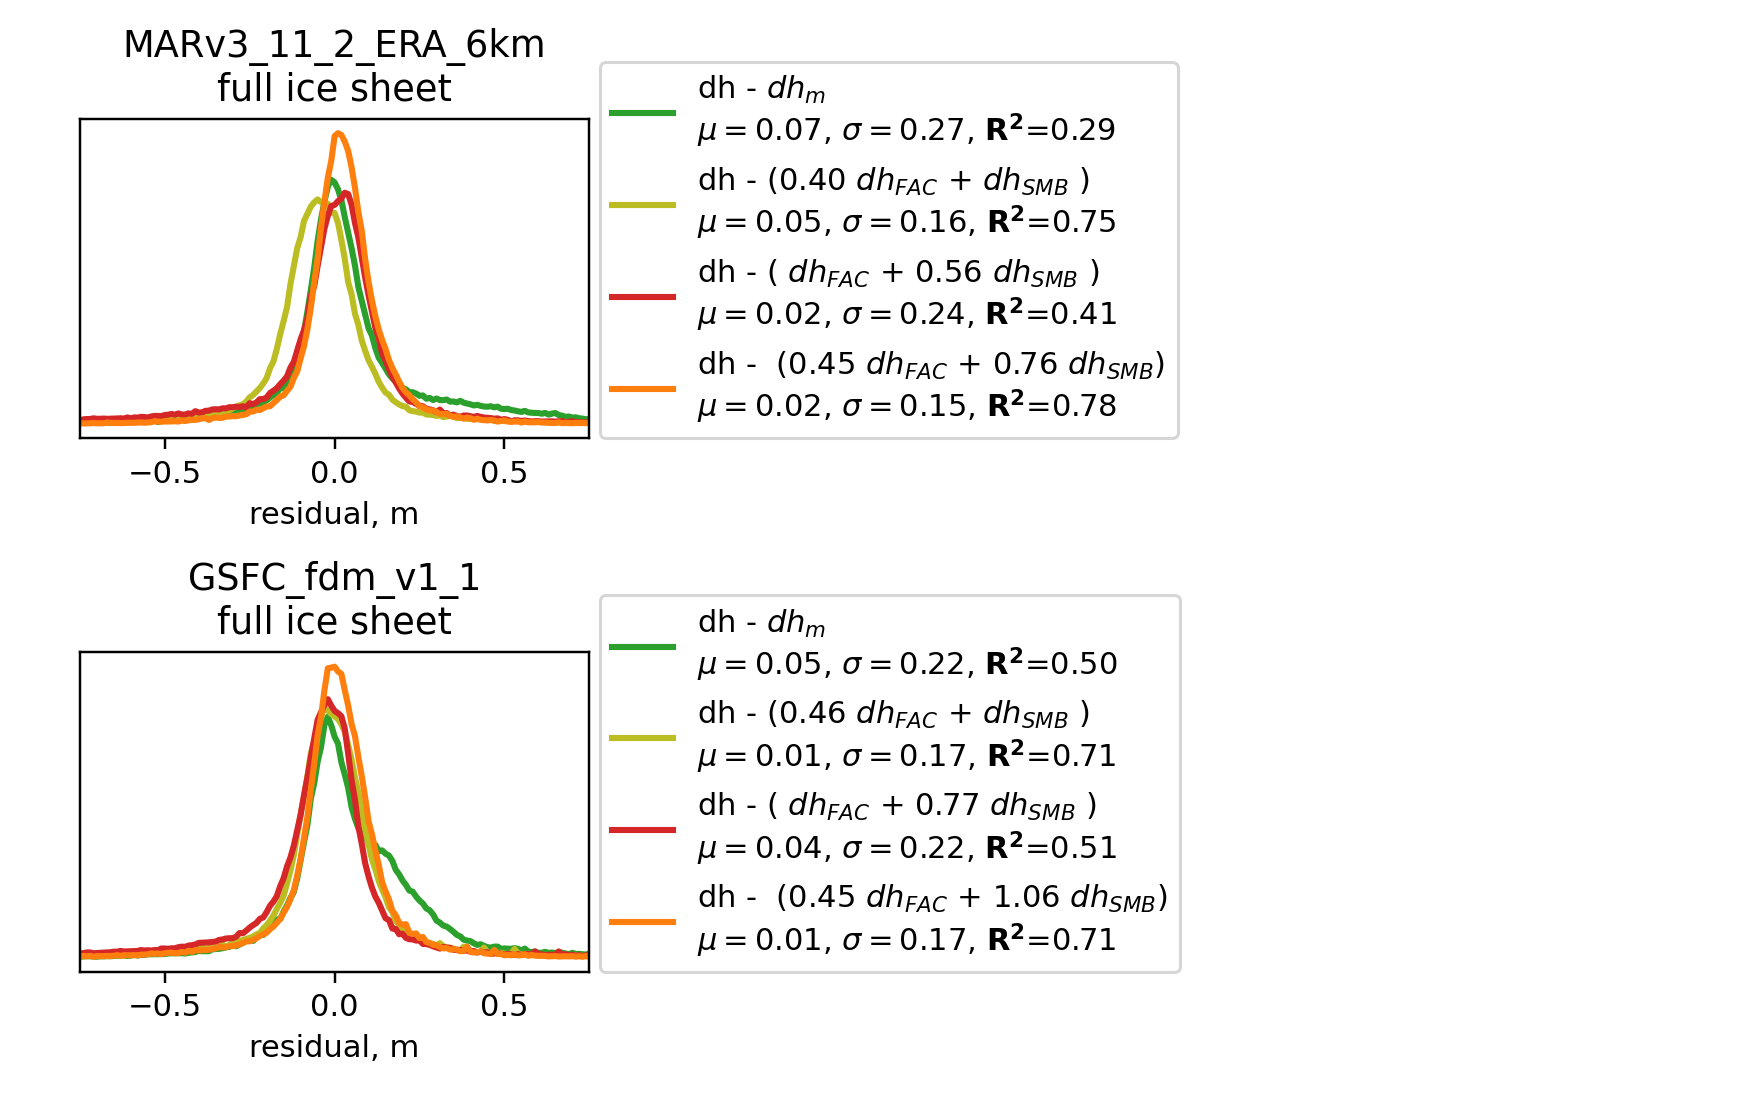

In [67]:
model='MARv3_11_2_ERA_6km'
#model='GSFC_fdm_v1_1'
fig=plt.figure(figsize=[8,5])
ax=fig.add_subplot(221)
fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=12)

fit_hists(Dsub, fits, plot_keys['smb_fac'], colors['smb_fac'], wt_field='pt_density', stats='all')
plt.title(model.replace('_zsurf','') + '\nfull ice sheet')
plt.gca().set_xlim([-0.75, 0.75])

model=model='GSFC_fdm_v1_1'
#model='GSFC_fdm_v1_1'
ax=fig.add_subplot(223)
fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density', n_sigma=12)
fit_hists(Dsub, fits, plot_keys['smb_fac'], colors['smb_fac'], wt_field='pt_density', stats='all')
plt.title(model.replace('_zsurf','') + '\nfull ice sheet')
plt.gca().set_xlim([-0.75, 0.75])


plt.tight_layout()

<IPython.core.display.Javascript object>


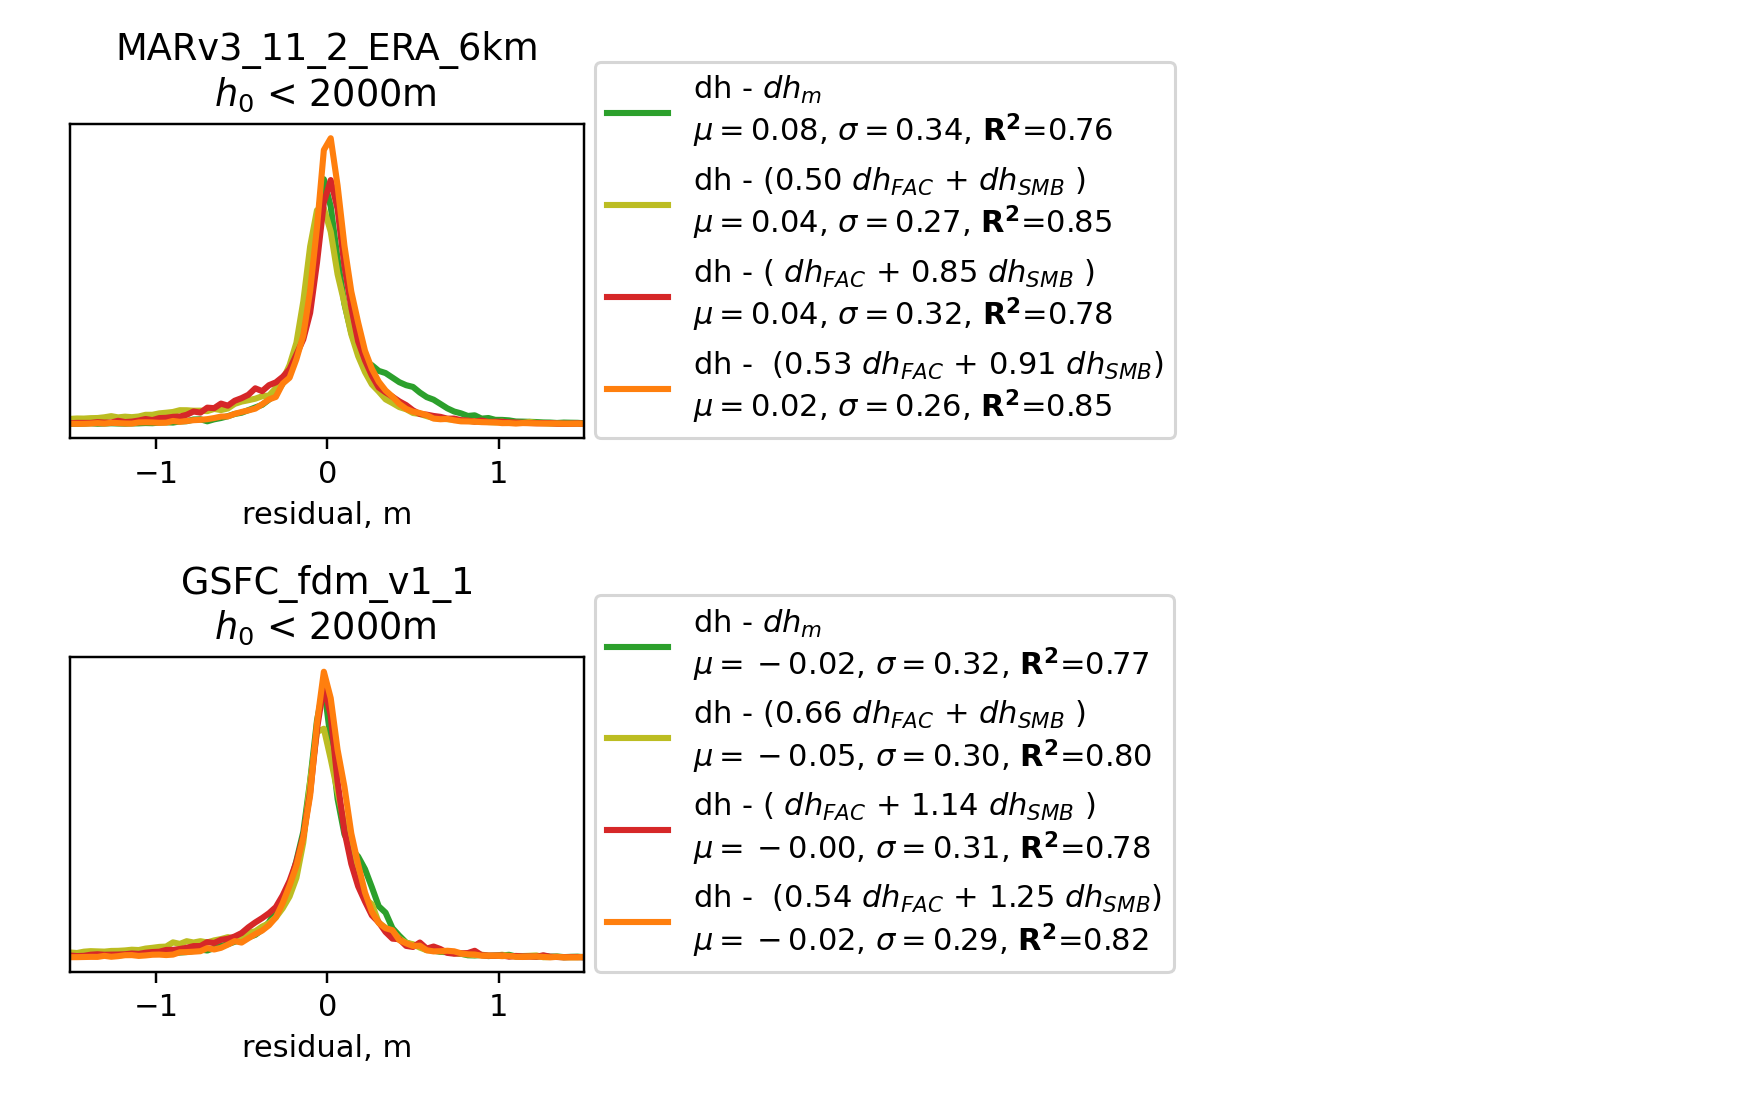

In [68]:
# Low elevation, both models

model='MARv3_11_2_ERA_6km'
#model='GSFC_fdm_v1_1'
fig=plt.figure(figsize=[8,5])
ax=fig.add_subplot(221)
fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 2000], wt_field='pt_density', n_sigma=12)
fit_hists(Dsub, fits, plot_keys['smb_fac'], colors['smb_fac'], wt_field='pt_density', stats='all', bins=np.arange(-2.12,  2.12, 0.04))
plt.title(model.replace('_zsurf','') + '\n$h_0$ < 2000m ')
plt.gca().set_xlim([-1.5, 1.5])

model='GSFC_fdm_v1_1'
#model='GSFC_fdm_v1_1'
ax=fig.add_subplot(223)
fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 2000], wt_field='pt_density', n_sigma=12)

fit_hists(Dsub, fits, plot_keys['smb_fac'], colors['smb_fac'], wt_field='pt_density', stats='all', bins=np.arange(-2.12,  2.12, 0.04))
plt.title(model.replace('_zsurf','') + '\n$h_0$ < 2000m ')
plt.gca().set_xlim([-1.5, 1.5])


plt.tight_layout()



<IPython.core.display.Javascript object>


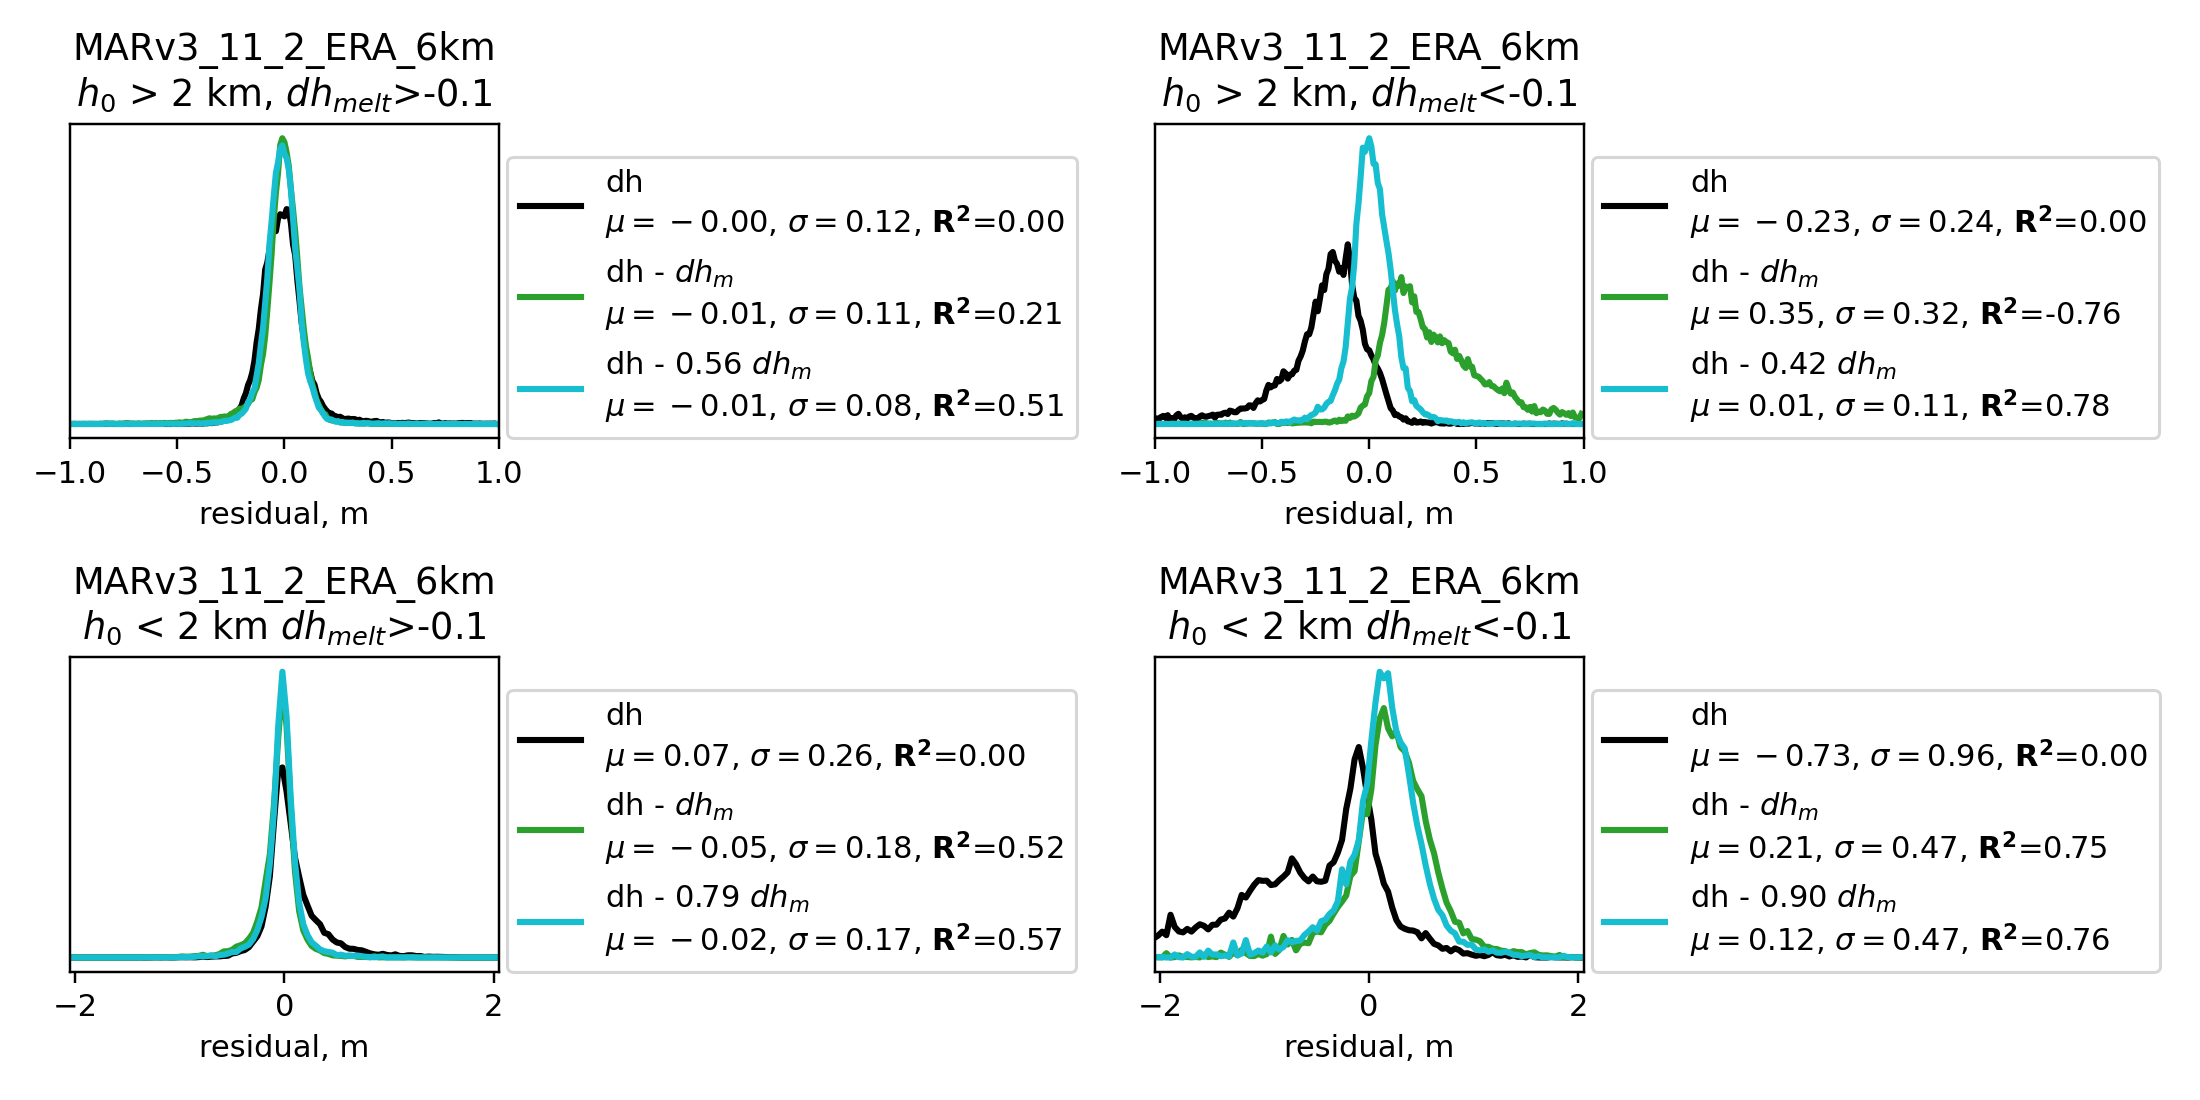

In [89]:
# double split : melt vs. no melt, high vs. low, regressing for total model
melt_only = lambda XX : (XX[XX.z_melt > 0.1])
no_melt = lambda XX : (XX[XX.z_melt <0.1])

columns={'$dh_{melt}$>-0.1':0, '$dh_{melt}$<-0.1':1}
melt_areas={'$dh_{melt}$>-0.1':no_melt, '$dh_{melt}$<-0.1':melt_only}
for model in ['MARv3_11_2_ERA_6km']:   
    fig=plt.figure(figsize=[10,5])
    hax=fig.subplots(2, 2)
    for key, fn in melt_areas.items():
             
        fits, Dsub=basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [2000, 5000], fn=fn, wt_field='pt_density', n_sigma=12)
        plt.sca(hax[0][columns[key]])
        fit_hists(Dsub, fits, plot_keys['hm'], colors['hm'], wt_field='pt_density', stats='msR')
        plt.title(model.replace('_zsurf','') + '\n$h_0$ > 2 km, ' + key)
        plt.gca().set_xlim([-1, 1])
        
        fits, Dsub=basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 2000], fn=fn, n_sigma=12, wt_field='pt_density')
        plt.sca(hax[1][columns[key]])
        fit_hists(Dsub, fits, plot_keys['hm'], colors['hm'], wt_field='pt_density', stats='msR', bins=np.arange(-2.12,  2.12, 0.04))
        plt.title(model.replace('_zsurf','') + '\n$h_0$ < 2 km '+key)
        plt.gca().set_xlim([-2.05, 2.05])

        
        plt.tight_layout()
    
#    for row in [0, 1]:
#        for col in [1, 3]:
#            hax[row][col].set_visible(False)

<IPython.core.display.Javascript object>


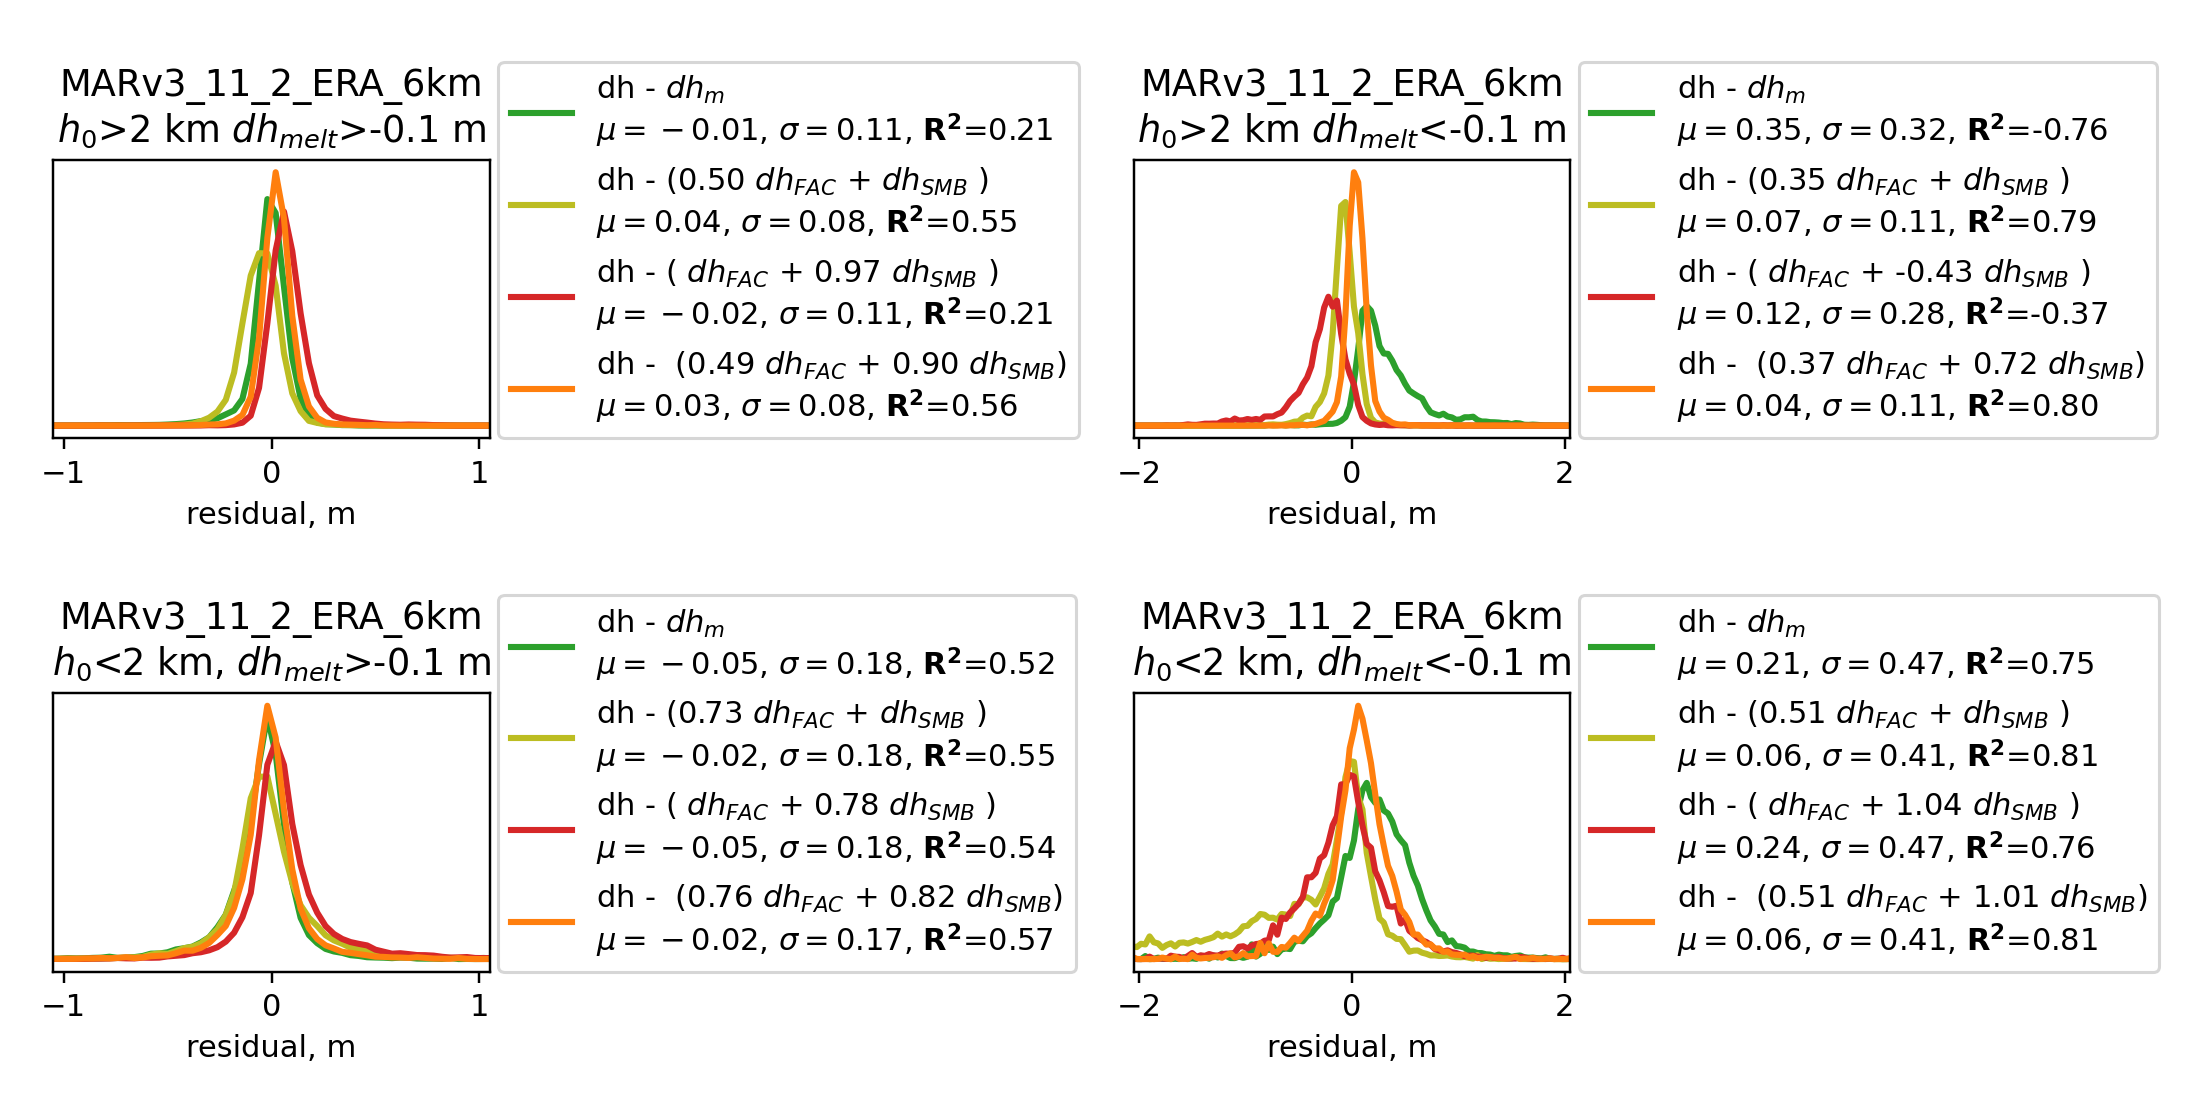

In [95]:
# double split : melt vs. no melt, high vs. low, regressing for total model

columns={'$dh_{melt}$>-0.1 m':0, '$dh_{melt}$<-0.1 m':1}
melt_areas={'$dh_{melt}$>-0.1 m':no_melt, '$dh_{melt}$<-0.1 m':melt_only}

for model in ['MARv3_11_2_ERA_6km']:#, 'GSFC_fdm_v1_1']:   
    fig=plt.figure(figsize=[10,5])
    hax=fig.subplots(2, 2)
    for key, fn in melt_areas.items():
        
 
        fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [2000, 5000], fn=fn, wt_field='pt_density', n_sigma=12)
        plt.sca(hax[0][columns[key]])
        fit_hists(Dsub, fits, plot_keys['smb_fac'], colors['smb_fac'], wt_field='pt_density', stats='msR', bins=np.arange(-2.12,  2.12, 0.04))
        plt.title(model.replace('_zsurf','') + '\n$h_0$>2 km '+key)
             
        fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 2000], fn=fn, wt_field='pt_density', n_sigma=12)
        plt.sca(hax[1][columns[key]])
        fit_hists(Dsub, fits, plot_keys['smb_fac'], colors['smb_fac'], wt_field='pt_density', stats='msR', bins=np.arange(-2.12,  2.12, 0.04))
        plt.title(model.replace('_zsurf','') + '\n$h_0$<2 km, ' + key)
  
        for ax in [hax[0][0], hax[1][0]]:
            ax.set_xlim([-1.05, 1.05])
        for ax in [hax[0][1], hax[1][1]]:
            ax.set_xlim([-2.05, 2.05])
        plt.tight_layout()
    


In [ ]:
SMB_scale=np.arange(0, 1.25, 0.05)
FAC_scale=np.arange(0, 1.25, 0.05)
sigma_maps={}
fits_dict={}
for model in ['MARv3_11_2_ERA_6km','GSFC_fdm_v1_1']:
    fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-20, 5000], wt_field='pt_density', n_sigma=12)
    wt=1/Dsub.pt_density
    sigma_maps[model]=np.zeros((SMB_scale.size, FAC_scale.size))
    ind=fits['A']['ind']
    fits_dict[model]=fits
    for iS, SMBsc in enumerate(SMB_scale):
        for iF, FACsc in enumerate(FAC_scale):
            temp=(Dsub.data-FACsc*Dsub.fac-SMBsc*Dsub.smb)
            temp -= np.nansum(temp[ind]*wt[ind])/np.nansum(wt[ind])
            sigma_maps[model][iS, iF] = np.sqrt(np.nansum(temp[ind]**2*wt[ind])/np.nansum(wt[ind]))

In [ ]:

plt.figure(figsize=[4, 6]);
colors={'MARv3_11_2_ERA_6km':'r','GSFC_fdm_v1_1':'b'}
for model in ['MARv3_11_2_ERA_6km','GSFC_fdm_v1_1']:
    #plt.imshow(sigma_map, extent=[-0.025, SMB_scale[-1]+.025, -0.025, FAC_scale[-1]+0.025], origin='lower')
    Clevel = np.sqrt(np.min(sigma_maps[model].ravel())**2+0.025*fits_dict[model]['A']['sigma']**2)
    plt.contour(FAC_scale, SMB_scale, sigma_maps[model], levels=[Clevel],colors=[colors[model]], origin='lower')
    ii,jj=np.unravel_index(np.argmin(sigma_maps[model]), sigma_maps[model].shape)
    plt.plot(FAC_scale[jj], SMB_scale[ii],marker='*', color=colors[model], label=model)
    plt.xlabel('FAC scale')
    plt.ylabel('SMB scale')
    
fac_scale_slope=(1-420/917)/(1-300/917)
plt.plot(fac_scale_slope*np.arange(0, 1, 0.05), np.arange(0, 1, 0.05),'k--', label=f'FAC scale ={fac_scale_slope:.2f} SMB scale')
plt.axis('equal')
plt.gca().set_xlim([0, 0.7])
plt.gca().set_ylim([0.25, 1.25])
plt.legend()
plt.tight_layout()

In [ ]:
print({model:1-np.min(sigma_maps[model][:,FAC_scale==1])**2/fits['A']['sigma']**2 for model in ['MARv3_11_2_ERA_6km','GSFC_fdm_v1_1']})
print({model:1-np.min(sigma_maps[model][SMB_scale==1,:])**2/fits['A']['sigma']**2 for model in ['MARv3_11_2_ERA_6km','GSFC_fdm_v1_1']})
print({model:1-np.min(sigma_maps[model].ravel())**2/fits['A']['sigma']**2 for model in ['MARv3_11_2_ERA_6km','GSFC_fdm_v1_1']})

In [ ]:
# check that by scaling the FAC and holding the SMB fixed at 1 we can get the exptected result

In [ ]:
1-np.min(sigma_maps[model][SMB_scale==1,:])**2/fits['A']['sigma']**2
fac_sc_best=FAC_scale[np.argmin(sigma_maps[model][SMB_scale==1,:])]

#0.025*fits_dict[model]['A']['sigma']**2
r0 = Dsub.data[ind]-fac_sc_best*Dsub.fac[ind] - Dsub.smb[ind]
r0 -= np.sum(r0*wt[ind])/np.sum(wt[ind])
print(np.sqrt(np.sum(r0**2*wt[ind])/np.sum(wt[ind])))


In [ ]:
ind=fits['A']['ind']
G=np.c_[np.ones_like(Dsub.fac[ind]), Dsub.fac[ind]]
W=spa.diags(wt[ind])
m=np.linalg.solve(G.T.dot(W.dot(G)), G.T.dot(W.dot(Dsub.data[ind])))
print(m)
r=Dsub.data[ind]-G.dot(m)
print(np.sqrt(np.sum(r**2*wt[ind])/np.sum(wt[ind])))

In [ ]:
F={}
DD={}
model='GSFC_fdm_v1_1'
F[model], DD[model]=basin_regessions(D, model, np.arange(1, 10), epochs[0:-1], [-20, 5000], wt_field='pt_density')

model='MARv3_11_2_ERA_6km'
F[model], DD[model]=basin_regessions(D, model, np.arange(1, 10), epochs, [-20, 5000], wt_field='pt_density')

In [ ]:

fig=plt.figure(figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
    for col, epoch in enumerate(epochs):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model)
        if model == 'Data':
            this_D=DD['MARv3_11_2_ERA_6km']
            temp=this_D[this_D.epoch==col]
            dh=F['MARv3_11_2_ERA_6km']['A']['r'][this_D.epoch==col]+F['MARv3_11_2_ERA_6km']['A']['m']
        else:
            this_D=DD[model]
            temp=this_D[this_D.epoch==col]            
            dh=F[model]['A+B*dh_m']['r'][this_D.epoch==col]    
        ind=np.argsort(np.abs(dh))
        if len(ind) > 0:
            hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
                vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m');


In [ ]:
fig=plt.figure(figsize=[8, 3])
ax=fig.subplots(1, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs

for col, epoch in enumerate(epochs):
    ax[ col].set_title(epoch.replace('-','\n to '))
    temp=D['MARv3_11_2_ERA_6km'][epoch]
    ind=np.argsort(-temp.z_melt)
    hi=ax[col].scatter(temp.x[ind], temp.y[ind], 1, c=-temp.z_melt[ind],\
                vmin=-2.5, vmax=2.5, cmap='Spectral');
    ax[col].set_xticks([])
    ax[col].set_yticks([])
    ax[col].set_aspect(1)
    ax[col].set_xlim(XR_default)
    ax[col].set_ylim(YR_default)
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='melt, m')


In [ ]:
fig=plt.figure(figsize=[8, 3])
ax=fig.subplots(1, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs

for col, epoch in enumerate(epochs):
    ax[ col].set_title(epoch.replace('-','\n to '))
    temp=D['MARv3_11_2_ERA_6km'][epoch]
    ind=temp.z_melt > .1
    ax[col].plot(temp.x, temp.y,'k.')
    ax[col].plot(temp.x[ind], temp.y[ind], 'r.');
    ax[col].set_xticks([])
    ax[col].set_yticks([])
    ax[col].set_aspect(1)
    ax[col].set_xlim(XR_default)
    ax[col].set_ylim(YR_default)
    

In [ ]:
N_melt=[]
for count, epoch in enumerate(epochs):
    N_melt += [np.nanmean(np.sum(D)['MARv3_11_2_ERA_6km'][epoch].z_melt > 0.1)]
N_melt=np.array(N_melt)
N_melt/N_melt.sum()

In [ ]:
# all by itself: maps of elevation change

fig=plt.figure(figsize=[10, 3.5])
ax=fig.subplots(1, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs

for col, epoch in enumerate(epochs):
    ax[ col].set_title(epoch.replace('-','\n to '))
    temp=D['MARv3_11_2_ERA_6km'][epoch].copy()
    temp=temp[temp.vel_mask==1]
    ind=np.argsort(np.abs(temp.data))
    hi=ax[col].scatter(temp.x[ind], temp.y[ind], 1, c=temp.data[ind],\
                vmin=-2.5, vmax=2.5, cmap='Spectral');
    ax[col].set_xticks([])
    ax[col].set_yticks([])
    ax[col].set_aspect(1)
    ax[col].set_xlim((-656740.6400490253, 726703.9765711618))
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='height change, m ')
#plt.tight_layout()
#plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='height change, m ')

In [ ]:
[ax1.get_xlim() for ax1 in ax]

In [ ]:
np.mean(D['MARv3_11_2_ERA_6km'][epoch].vel_mask)

## Sector regressions

In [ ]:
model='MARv3_11_2_ERA_6km'
#model='GSFC_fdm_v1_1'

fits, Dsub=basin_regessions(D, model, np.arange(4, 5), epochs[0:-1], [-500, 5000], fn=melt_only)
fig=plt.figure(figsize=[8,8])

ax=fig.add_subplot(221)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nSoutheast,\nMelt')
plt.gca().set_xlim([-1., 1.])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

fits, Dsub=basin_regessions(D, model, np.arange(4, 5), epochs[0:-1], [-500, 5000], fn=no_melt)
ax=fig.add_subplot(223)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nSoutheast,\nNo Melt')
plt.gca().set_xlim([-0.75, 0.75])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

plt.tight_layout()

In [ ]:
#model='MARv3_11_2_ERA_6km'
model='GSFC_fdm_v1_1'

fits, Dsub=basin_regessions(D, model, np.arange(4, 5), epochs[0:-1], [-500, 5000], fn=melt_only)
fig=plt.figure(figsize=[8,8])

ax=fig.add_subplot(221)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nSoutheast,\nMelt')
plt.gca().set_xlim([-1, 1])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

fits, Dsub=basin_regessions(D, model, np.arange(4, 5), epochs[0:-1], [-500, 5000], fn=no_melt)
ax=fig.add_subplot(223)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nSoutheast,\nNo Melt')
plt.gca().set_xlim([-0.5, 0.5])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

plt.tight_layout()

In [ ]:
model='MARv3_11_2_ERA_6km'
#model='GSFC_fdm_v1_1'

fits, Dsub=basin_regessions(D, model, np.arange(7, 8), epochs[0:-1], [-500, 5000], fn=melt_only)

fig=plt.figure(figsize=[8,8])

ax=fig.add_subplot(221)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nNorthwest,\nMelt')
plt.gca().set_xlim([-1., 1.])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

fits, Dsub=basin_regessions(D, model, np.arange(7, 8), epochs[0:-1], [-500, 5000], fn=no_melt)
ax=fig.add_subplot(223)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nNorthwest,\nNo Melt')
plt.gca().set_xlim([-0.75, 0.75])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

plt.tight_layout()

In [ ]:
#model='MARv3_11_2_ERA_6km'
model='GSFC_fdm_v1_1'

fits, Dsub=basin_regessions(D, model, np.arange(7, 8), epochs[0:-1], [-500, 5000], fn=melt_only)
fig=plt.figure(figsize=[8,8])

ax=fig.add_subplot(221)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nNorthwest,\nMelt')
plt.gca().set_xlim([-1., 1.])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

fits, Dsub=basin_regessions(D, model, np.arange(7, 8), epochs[0:-1], [-500, 5000], fn=no_melt)
ax=fig.add_subplot(223)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors)
plt.title(model.replace('_zsurf','') + '\nNorthwest,\nNo Melt')
plt.gca().set_xlim([-0.75, 0.75])
#print(calc_bvar(Dsub, fits, 'A'))
#print(calc_bvar(Dsub, fits, 'A+dh_m'))

plt.tight_layout()

In [ ]:
DD=D[models[0]]
N_epoch = np.array([DD[epoch].x.size for epoch in epochs])
print(N_epoch)
print(N_epoch.sum())

In [ ]:
plt.figure(); 

dh_fake=D[model][epoch].data + 0.25
e_fake=np.random.randn(dh_fake.size)*0.1

#count, bins = np.histogram(dh_fake+e_fake, np.arange(-2.5, 2.5, 0.02));
plt.plot(bins[:-1]+0.01, count)

In [ ]:
model="MARv3_11_2_ERA_6km"
plt.figure(); plt.hist(D[model][epochs[-2]].smb, 1000)


# Cycle-3 material

In [ ]:
data_file=os.path.join(data_root+'/combined_xover_at_differences_wrtc3_'+version)


epochs_c3=strings_xover+['2019.Q2-2019.Q3', '2019.Q2-2019.Q4', '2019.Q2-2020.Q1']
D_c3={}
with h5py.File(data_file,'r') as h5f:
    models=list(h5f.keys())
    print(models)
for model in models:
    D_c3[model]={}
    for epoch in epochs_c3:
        this_group='/'.join(['',model, epoch])
        D_c3[model][epoch]=pc.data().from_h5(data_file, group=this_group)
        D_c3[model][epoch].assign({'basin':np.floor(dbi.__call__((D_c3[model][epoch].y, D_c3[model][epoch].x))*10)/10})


In [ ]:
model='MARv3_11_2_ERA_6km'
fits_c3, Dsub_c3 = basin_regessions(D_c3, model, np.arange(1,9), epochs_c3[0:-1], [-20, 5000])

fig=plt.figure()
ax=fig.add_subplot(111)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub_c3, fits_c3, fits_c3.keys(), colors)
plt.title(model.replace('_zsurf','') + ' all basins, vs 2020 Q2')

In [ ]:
F_c3={}
DD_c3={}
model='GSFC_fdm_v1_1'
F_c3[model], DD_c3[model]=basin_regessions(D_c3, model, np.arange(1, 10), epochs_c3[0:-1], [-20, 5000])

model='MARv3_11_2_ERA_6km'
F_c3[model], DD_c3[model]=basin_regessions(D_c3, model, np.arange(1, 10), epochs_c3, [-20, 5000])



In [ ]:
fig=plt.figure(figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
    for col, epoch in enumerate(epochs_c3):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model.replace('_zsurf','').replace('_6km',''))
        if model == 'Data':
            this_D=DD_c3['MARv3_11_2_ERA_6km']
            temp=this_D[this_D.epoch==col]
            dh=F_c3['MARv3_11_2_ERA_6km_zsurf']['A']['r'][this_D.epoch==col]
        else:
            this_D=DD_c3[model]
            temp=this_D[this_D.epoch==col]            
            dh=F_c3[model]['A+ B*dh_m + C*h_star*dh_m']['r'][this_D.epoch==col]    
        if len(dh) > 0:
            ind=np.argsort(np.abs(dh))    
            hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 2, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m')


# FAKE DATA FOR CONCEPTUAL PLOT

In [ ]:

plt.figure(figsize=[3, 6])
hax=plt.gcf().subplots(3, 1)


bbb=np.arange(-1, 1, 0.01)
dh_fake=D[model][epoch].smb*3
dh_noise = np.random.randn(*dh_fake.shape)*.05+0.1
N,b=np.histogram(dh_fake + dh_noise, bbb )
bc=b[:-1]+(b[1]-b[0])/2
hax[0].plot(bc, N)
hax[0].set_yticks([])
hax[0].set_xlabel('dh, m')
hax[0].set_title('measured')

N,b=np.histogram(dh_fake + dh_noise, bbb )
hax[1].plot(bc, N,'r')
hax[1].set_yticks([])
hax[1].set_xlabel('dh, m')
hax[1].set_title('modeled')

N,b=np.histogram(dh_noise, bbb )
hax[2].plot(bc, N,'g')
hax[2].set_yticks([])
hax[2].set_xlabel('dh, m')
hax[2].set_title('corrected')

plt.tight_layout()

In [ ]:
#model='MARv3_11_2_ERA_6km'
model='GSFC_fdm_v1_1'

fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density')

fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(121)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors, wt_field='pt_density')
plt.title(model.replace('_zsurf','') + '\nall basins')
plt.gca().set_xlim([-0.75, 0.75])


In [ ]:
junk=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density')


In [ ]:
junk is None

In [ ]:
model

In [ ]:
model='MARv3_11_2_ERA_6km'
#model='GSFC_fdm_v1_1'
fits, Dsub=smb_fdm_regressions(D, model, np.arange(1, 10), epochs[0:-1], [-500, 5000], wt_field='pt_density')

fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(121)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub, fits, fits.keys(), colors, wt_field='pt_density')
plt.title(model.replace('_zsurf','') + '\nall basins')
plt.gca().set_xlim([-0.75, 0.75])

In [ ]:
model='MARv3_11_2_ERA_6km'
#model='GSFC_fdm_v1_1'
# determine the inital three-sigma edit on the data

fits, Dsub=basin_regessions(D, model, np.arange(1, 9), epochs[0:-1], [-500, 5000], wt_field='pt_density')

# reconstruct D from D1 (now initial three-sigma edit is applied)
Dsub=Dsub[fits['A']['ind']]
D1={model:{epoch:Dsub[Dsub.epoch==epoch_ind] for epoch_ind, epoch in enumerate(epochs[0:-1])}}

fits1, Dsub1 = basin_regessions(D1, model, np.arange(1, 10), epochs[0:-1], [-500, 5000],  initial_iterations=0, wt_field='pt_density')


In [ ]:

r_all={key:[] for key in ['A','A+B*dh_m']}
w_all={key:[] for key in ['A','A+B*dh_m']}

#plt.figure()
sigmas={}
Ms={}
for basin in range(1,9):
    for h_range in [(-500, 2000), (2000, 5000)]:
        fits_B, Dsub_B=basin_regessions(D1, model, [basin], epochs[0:-1], h_range, initial_iterations=0, wt_field='pt_density')
        sigmas[(basin, h_range)]={}
        Ms[(basin, h_range)]={}
        #plt.plot(Dsub_B.x, Dsub_B.y,'.')

        for key in ['A','A+B*dh_m']:
            r_all[key] += [fits_B[key]['r'][fits_B[key]['ind']] + fits_B[key]['m'][0]]
            w_all[key] += [fits_B[key]['wt'][fits_B[key]['ind']]]
            sigmas[(basin, h_range)][key]=fits_B[key]['sigma']
            Ms[(basin, h_range)][key]=fits_B[key]['m']
sigma_variable={}
for key in ['A','A+B*dh_m']:
    r_all[key]=np.concatenate(r_all[key], axis=0)
    w_all[key]=np.concatenate(w_all[key], axis=0)
    sigma_variable[key] = np.sqrt(np.sum(r_all[key]**2*w_all[key])/np.sum(w_all[key]))

sigma_uniform={}
for key in ['A','A+B*dh_m']:
    ind=fits1[key]['ind']
    sigma_uniform[key] = np.sqrt(np.sum((fits1[key]['m'][0]+fits1[key]['r'][ind])**2*fits1[key]['wt'][ind])/np.sum(fits1[key]['wt'][ind]))


In [ ]:
{key:f"{Ms[key]['A+B*dh_m'][1]:2.3f}' for key in Ms}
#{key:Ms[key]['A'][0] for key in Ms}

In [ ]:
sigma_variable

In [ ]:
sigma_uniform

In [ ]:
! h5ls /Volumes/ice1/tyler/MAR/MARv3.11.2/Greenland/6km_ERA5/MARv3.11.2-ERA5-6km-2018_subset.nc


In [ ]:
with h5py.File('/Volumes/ice1/tyler/MAR/MARv3.11.2/Greenland/6km_ERA5/MARv3.11.2-ERA5-6km-2018_subset.nc','r') as h5f:
    zs=np.array(h5f['SH'])

In [ ]:
plt.figure(); plt.imshow(zs, origin='lower')

In [ ]:
# 144, 60 is in the mid-SW
# Dims of R01 are:
#RO1                      Dataset {365/Inf, 18, 446, 240}
with h5py.File('/Volumes/ice1/tyler/MAR/MARv3.11.2/Greenland/6km_ERA5/MARv3.11.2-ERA5-6km-2018_subset.nc','r') as h5f:
    Rsurf=np.array(h5f['RO1'][:, 0,300, :])
    x=np.array(h5f['X12_251'])
    zs=np.array(h5f['SH'][300, :])

In [ ]:
mask=(Rsurf>0).astype(float)
mask[mask==0]=np.NaN
plt.figure(); plt.imshow(Rsurf*mask, cmap='Blues', clim=[300, 917], extent=[x[0], x[-1], 1, 365], origin='lower'); 
plt.xlabel('x, km')
plt.ylabel('DOY')
plt.colorbar(label='density, $kg m^{-3}$')